In [59]:
### import libraries
import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential

from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Conv2D, Flatten
from keras import backend as K
from keras.models import load_model
from keras.utils.vis_utils import plot_model

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib
# matplotlib.use("Agg") # set the matplotlib backend so figures can be saved in the background
 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import datetime
import tensorflow as tf

import json

In [60]:
def read_config(p):
    '''read from configuration file'''
    with open(p) as f:
        d = json.load(f)
    
    #fix trailing slash
    if(d['df'][-1] != '/'):
        d['df'] += '/'
    
    print("path: ", d['df'])
    print("train labels: ", d['train_labels'])
    print("test_labels: ", d['test_labels'])
    print("all_labels: ", d['all_labels']),
    print("processing labels: ", d['processing_labels'])
    print("batch size: ", d['batch_size'])
    return d['df'], d['train_labels'], d['test_labels'], d['all_labels'], d['processing_labels'], d['batch_size']

In [72]:
[df_path, train_labels, test_labels, all_labels, processing_labels, batch_size] = read_config('config.json')
x_col = processing_labels['x_col']
y_col = processing_labels['y_col']
number_of_classes = len(y_col)

# import train data info from valid.csv
dtrain=pd.read_csv(df_path + train_labels, nrows=2000)
dtrain = dtrain.fillna(0)

# import valid data info from valid.csv
dtest = pd.read_csv(df_path + test_labels)
dtest = dtest.fillna(0)

#add dnew to dtrain to re-split since valid data in data set is very small
dtrain = dtrain.append(dtest)

#pre-process data: remove Lateral images
dtrain = dtrain[~dtrain[dtrain.columns[3]].str.contains("Lateral")]

#pre-process data: drop selected features - only images as inputs
#drop all features that are not included in processing_features
to_drop = list(set(all_labels) - set(y_col))
to_drop.remove(x_col)
print('dropping columns....\n', to_drop)
dtrain = dtrain.drop(to_drop, axis=1)

#uncertain examples make them positive
dtrain = dtrain.replace(-1,1)

dtrain.drop(dtrain.loc[(dtrain['Pneumonia'] == 0) & (dtrain['Pneumothorax'] == 0) & (dtrain['Lung Lesion'] == 0)].index, inplace=True)
print(dtrain.shape)

path:  CheXpert-v1.0-small/
train labels:  train.csv
test_labels:  valid.csv
all_labels:  ['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Pneumonia', 'Lung Lesion', 'No Finding', 'Consolidation', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
processing labels:  {'x_col': 'Path', 'y_col': ['Pneumothorax', 'Pneumonia', 'Lung Lesion']}
batch size:  32
dropping columns....
 ['Support Devices', 'Lung Opacity', 'AP/PA', 'Sex', 'Pleural Other', 'Cardiomegaly', 'Atelectasis', 'Fracture', 'Pleural Effusion', 'Frontal/Lateral', 'Edema', 'Consolidation', 'No Finding', 'Age', 'Enlarged Cardiomediastinum']
(372, 4)


In [73]:
count = 0
for index, row in dtrain.iterrows():
#     print(row['Pneumonia'], row['Lung Lesion'])
    if row['Pneumonia'] == 0.0 and row['Lung Lesion'] == 0.0 and row['Pneumothorax'] == 0.0:
        count += 1
print(count)

0


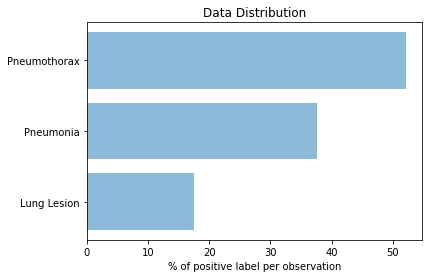

<Figure size 432x288 with 0 Axes>

In [74]:
%matplotlib inline
features_size=[]
features_data =[]
features_name=[]
for feature in list(dtrain.columns[1:4]):
    data_feature = dtrain.loc[dtrain[feature] == 1]
    features_size.append(data_feature.shape[0])
    features_data.append(data_feature)
    features_name.append(feature)

objects = list(dtrain.columns[1:number_of_classes+1])
y_pos = np.arange(len(objects))
performance = np.array(features_size)/dtrain.shape[0]*100
# print(features_data)
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('% of positive label per observation')
plt.title('Data Distribution')
plt.show()
plt.savefig('DataDistribute.png', bbox_inches='tight')

In [75]:
### split data into train/valid/test
#random suffle on entire dataset
dtrain = dtrain.sample(frac=1)
#Use 10% as validation set
dvalid_size = round(0.1*dtrain.shape[0])
#Use 10% as test set
dtest_size = dvalid_size

dtr = dtrain[0:dtrain.shape[0]-dvalid_size-dtest_size+1]
dv = dtrain[dtrain.shape[0]-dvalid_size-dtest_size:dtrain.shape[0]-dvalid_size+1]
dte = dtrain[dtrain.shape[0]-dvalid_size:dtrain.shape[0]+1]

print("Train set -\t", dtr.shape)
print("Valid set -\t", dv.shape)
print("Test set -\t", dte.shape)

Train set -	 (299, 4)
Valid set -	 (38, 4)
Test set -	 (37, 4)


In [85]:
### data generation for Keras 
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen=ImageDataGenerator(rescale=1./255.)

target_size = (224,224)
#target_size = (299,299)
# target_size = (75,75)
train_generator=train_datagen.flow_from_dataframe(dataframe=dtr, directory=None , 
                                                  x_col="Path", y_col=list(dtr.columns[1:number_of_classes+1]), 
                                                  class_mode="other", 
                                                  target_size=target_size, 
                                                  batch_size=batch_size)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=dv, directory=None , 
                                                  x_col="Path", y_col=list(dv.columns[1:number_of_classes+1]), 
                                                  class_mode="other", 
                                                  target_size=target_size, 
                                                  batch_size=batch_size)
test_generator=test_datagen.flow_from_dataframe(dataframe=dte, directory=None , 
                                                x_col="Path", y_col=list(dte.columns[1:number_of_classes+1]), 
                                                class_mode="other", 
                                                target_size=target_size, 
                                                shuffle = False, batch_size=1)

Found 299 validated image filenames.
Found 38 validated image filenames.
Found 37 validated image filenames.


In [93]:
# ### model architecture design/selection

#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(number_of_classes, activation='sigmoid'))

adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 220, 220, 32)      18464     
_________________________________________________________________
flatten_19 (Flatten)         (None, 1548800)           0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 4646403   
Total params: 4,666,659
Trainable params: 4,666,659
Non-trainable params: 0
_________________________________________________________________


In [92]:
num_epochs = 10
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

#Tensorboard
log_dir = "logs/simple_model/"# + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_h = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=num_epochs,
                    callbacks=[tensorboard_callback])

# save model
model.save("model_DenseNet121_TF_Simple.h5")

Epoch 1/10
9/9 [==============================] - 47s 5s/step - loss: 1.6863 - accuracy: 0.4093 - val_loss: 0.9588 - val_accuracy: 0.5938
Epoch 2/10
9/9 [==============================] - 46s 5s/step - loss: 1.0774 - accuracy: 0.4410 - val_loss: 0.8681 - val_accuracy: 0.2812
Epoch 3/10
9/9 [==============================] - 55s 6s/step - loss: 0.6872 - accuracy: 0.3810 - val_loss: 0.5629 - val_accuracy: 0.5312
Epoch 4/10
9/9 [==============================] - 37s 4s/step - loss: 0.5889 - accuracy: 0.4514 - val_loss: 0.6341 - val_accuracy: 0.4688
Epoch 5/10
9/9 [==============================] - 57s 7s/step - loss: 0.5371 - accuracy: 0.5924 - val_loss: 0.5829 - val_accuracy: 0.5000
Epoch 6/10
9/9 [==============================] - 39s 5s/step - loss: 0.4812 - accuracy: 0.6189 - val_loss: 0.5598 - val_accuracy: 0.5312
Epoch 7/10
9/9 [==============================] - 40s 4s/step - loss: 0.4335 - accuracy: 0.7969 - val_loss: 0.5423 - val_accuracy: 0.5938
Epoch 8/10
9/9 [==================

In [83]:
# load my trained model 
model_F = load_model('model_DenseNet121_TF_Simple.h5')
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [84]:
### prediction and performance assessment
test_generator.reset()
pred=model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
pred_bool = (pred >= 0.5)

y_pred = np.array(pred_bool,dtype =int)

dtest = dte.to_numpy()
y_true = np.array(dtest[:,1:number_of_classes+1],dtype=int)

print(classification_report(y_true, y_pred,target_names=list(dtr.columns[1:number_of_classes+1])))

/usr/local/lib/python3.9/site-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

 Lung Lesion       0.12      0.14      0.13         7
   Pneumonia       0.00      0.00      0.00        12
Pneumothorax       0.54      1.00      0.70        20

   micro avg       0.47      0.54      0.50        39
   macro avg       0.22      0.38      0.28        39
weighted avg       0.30      0.54      0.38        39
 samples avg       0.50      0.55      0.52        39



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
score, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST)
print('Test score:', score)
print('Test accuracy:', acc)

/usr/local/lib/python3.9/site-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


KeyboardInterrupt: 